# Image Classification - Hristo Hristov

## Introduction
My personal challenge will be to make an A.I. model that can do landscapes calssifcation. The 6 landscapes include: buildings, forests, glaciers, mountains, seas and streets. 


In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

### Loading data

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    
    datasets = ['data/seg_train/seg_train', 'data/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading data/seg_train/seg_train


100%|█████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:02<00:00, 937.81it/s]


Loading data/seg_test/seg_test


100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 1240.09it/s]


### Visualization and image exploration

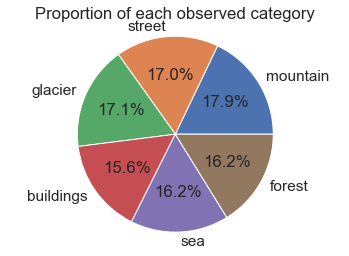

In [5]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

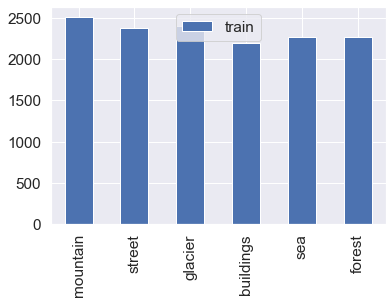

In [6]:
pd.DataFrame({'train': train_counts,
                    }, 
             index=class_names
            ).plot.bar()
plt.show()

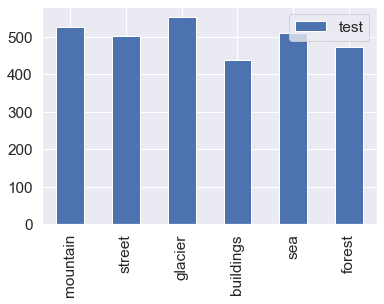

In [7]:
pd.DataFrame({'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Scaling the images

In [8]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [9]:
def display_examples(class_names, images, labels):
 
### Display 25 random images from the dataset
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    
    for i in range(25):
        index = np.random.randint(images.shape[0])
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[index], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[index]])
    plt.show()

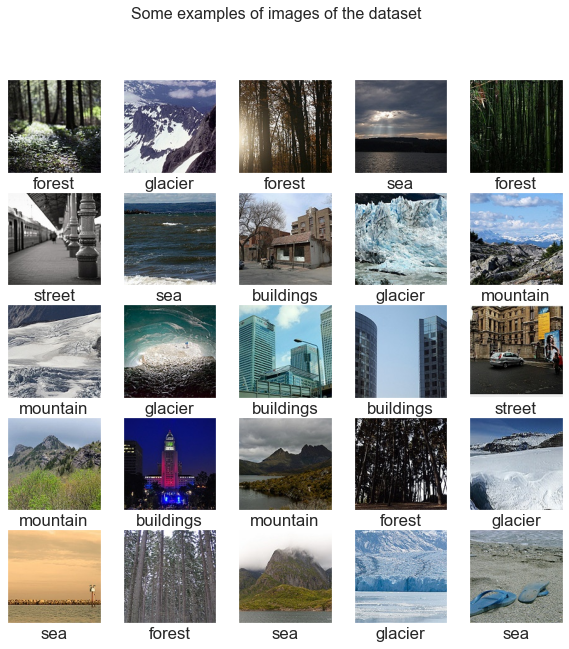

In [10]:
display_examples(class_names, train_images, train_labels)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [12]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
import time

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.perf_counter()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.perf_counter() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

Epoch 1/2
395/395 [==============================] - 205s 517ms/step - loss: 1.0164 - accuracy: 0.6080 - val_loss: 0.9567 - val_accuracy: 0.6645
Epoch 2/2
395/395 [==============================] - 201s 510ms/step - loss: 0.6492 - accuracy: 0.7622 - val_loss: 0.7215 - val_accuracy: 0.7272


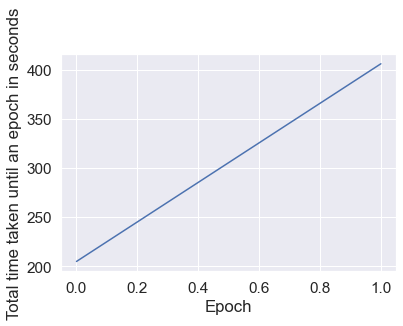

In [14]:
timeittakes = timecallback()
prediction = model.fit(train_images, train_labels, batch_size=32, epochs=2, validation_split = 0.1,callbacks = [timeittakes])

In [29]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.legend()
    plt.show()

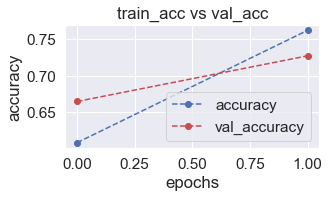

In [30]:
plot_accuracy_loss(prediction)

In [17]:
evaluation = model.evaluate(test_images, test_labels)

94/94 [==============================] - 14s 153ms/step - loss: 0.6897 - accuracy: 0.7550
